# BIOMEDICAL IMAGE ANALYSIS IN PYTHON
[datacamp.com](datacamp.com)



#CHAPTER 2: MASKS AND FILTERS

In [ ]:
#Project Folder:
%cd /content/drive/MyDrive/Biomedical_Image_Processing_Datacamp

/content/drive/MyDrive/Biomedical_Image_Processing_Datacamp


## IMAGE INTENSITIES
In this chapter, we'll discuss masks and filters, two techniques that emphasize important features in images. To leverage them well, you must have a thorough understanding of your data's distribution of intensity values.

### Pixels and voxels
The building blocks of medical images are pixels and voxels. Each of these elements has two properties: an intensity value and a location in space. The meaning of the intensity value depends on the imaging modality. For example, pixels in this x-ray image, or radiograph, are brighter in dense tissue such as bone, because it absorbs more radiation than other types.

#### Exercise: 

In this chapter, we will work with a hand radiograph from a 2017 Radiological Society of North America competition. X-ray absorption is highest in dense tissue such as bone, so the resulting intensities should be high. Consequently, images like this can be used to predict "bone age" in children.

To start, let's load the image and check its intensity range.

The image datatype determines the range of possible intensities: e.g., 8-bit unsigned integers (uint8) can take values in the range of 0 to 255. A colorbar can be helpful for connecting these values to the visualized image.

In [ ]:
'''

import imageio
import numpy as np
import matplotlib.pyplot as plt

# Load the radiograph
im = imageio.imread('./Data/ID00007637202177411956430/dicom_00000001_000.dcm')
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()
#format_and_render_plot()
'''

"\n#THIS IS JUST ANOTHER IMAGE...\n\nimport imageio\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Load the radiograph\nim = imageio.imread('dicom_00000001_000.dcm')\nprint('Data type:', im.dtype)\nprint('Min. value:', im.min())\nprint('Max value:', im.max())\n\n# Plot the grayscale image\nplt.imshow(im, vmin=0, vmax=255)\nplt.colorbar()\n#format_and_render_plot()\n"

Data type: uint8
Min. value: 0
Max value: 255


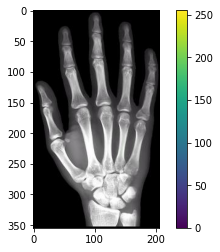

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Load the radiograph
im = imageio.imread('./Images/hand_xray.jpg')
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()
#format_and_render_plot()

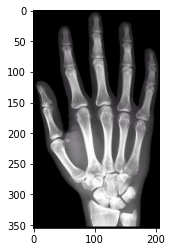

In [ ]:
# Draw the image in grayscale
plt.imshow(im, cmap='gray')

# Render the image
plt.show()

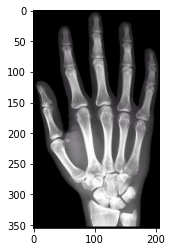

In [ ]:
# Draw the image with greater contrast
plt.imshow(im, cmap='gray', vmin=-200, vmax=200)

# Render the image
plt.show()

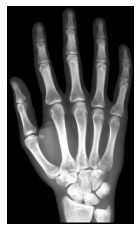

In [ ]:
# Remove axis ticks and labels
plt.imshow(im, cmap='gray')
plt.axis('off')


# Render the image
plt.show()

### Data types and image size
The range of values allowed in an image is determined by its data type. Generally, lower-bit integers are preferred for images, since memory usage increases dramatically for larger data types. If all values in the image are positive, then unsigned integers can cover the widest range of values while taking up the least amount of memory. You will commonly see images scaled by the value 255, which is the maximum value for 8-bit unsigned integers. You can see the difference in memory usage by calling the size attribute of the array. The x-ray we just saw is read by ImageIO as an 8-bit unsigned integer. It takes up about 153 kB. If we convert it to a 64-bit integer, however, the same information now takes up more than a megabyte of space.

### Histograms
Histograms summarize the distribution of intensity values in an image. They bin each pixel by its value and then count each bin. SciPy, and especially its Ndimage module, contain some essential tools for image analysis. We'll dig deeper into SciPy throughout this course. To generate a histogram for the foot x-ray, we first import SciPy's Ndimage module as ndi. Then, we call ndimage dot histogram() and pass in our array. The histogram() function requires us to specify values for the minimum, maximum, and the number of bins. Since our image is an 8-bit unsigned integer, our range is from 0 to 255, with 256 possible values. This returns a 256 element vector with the count of pixels at each intensity value. Plotting the data as a line plot reveals a highly skewed distribution, with many low values and a wider range of high values.

#### Exercise: Histograms

Histograms display the distribution of values in your image by binning each element by its intensity then measuring the size of each bin.

The area under a histogram is called the cumulative distribution function. It measures the frequency with which a given range of pixel intensities occurs.

For this exercise, describe the intensity distribution in im by calculating the histogram and cumulative distribution function and displaying them together.


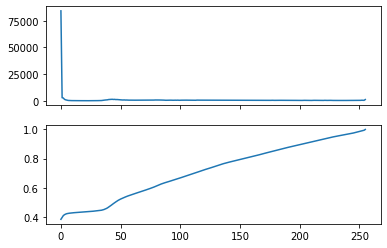

In [ ]:
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi 

# Create a histogram, binned at each possible value
hist = ndi.histogram(im, min =0, max=255, bins=256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram')
axes[1].plot(cdf, label='CDF')
#format_and_render_plot()

### Equalization
Skewed distributions are common in medical images: background intensities are usually low and take up a lot of image space. There are ways to modify the intensity distribution. For example, histogram equalization redistributes values based on their abundance in the image. We can perform equalization with the aid of the cumulative distribution function, which shows the proportion of pixels that fall within a given range. Here, we can see that about half the pixels have values less than 32. To equalize the image, we could redistribute these intensity values until they are more evenly represented.

Equalizing the histogram is actually pretty straightforward. First, we generate the histogram. Then, we calculate the cumulative distribution function by taking the rolling sum of the histogram and dividing it by the total number of pixels. Then, we apply the function to our image and rescale by 255. Plotting the original and equalized image shows that we have increased the pixel intensities for several areas. This has made our foot stand out more clearly, but it has also given extra weight to some background areas. For biomedical applications, global equalization, such as this, should be done with caution, but the principle of redistributing intensity values is a useful one to keep in mind.

## MASKS

You can restrict your analysis to only the most important parts of an image by creating and applying image masks.

A mask is a Boolean array which serves as a screen to remove undesirable pixels. Masks must retain the same dimensions as the original image so that the two can be overlaid.



###Creating masks
One way to create masks is to find all pixels in an image that satisfy a certain condition. For example, let's create a three by three array of ascending values. If we test for values greater than 5, we will return a three by three array where the values are True when they greater than 5, and False when they are less. Logical operations include comparisons and tests of equivalence. You can also chain operations together to select a specific range of pixels.

Let's look at this in action. Recall that the foot x-ray we have been working with has an intensity distribution like this. We see that there is a steep drop-off around 32, so let's select values greater than this. This seems to do quite a good job highlighting the foot.

Bone is the highest intensity tissue in an x-ray, and if we increase our threshold to 64, we create a rough bone mask. Finally, we can create a mask of non-bone tissue by finding pixels that are in mask 1 and not in mask 2. The selected pixels are in the foot but are not part of the bone. They seem to be related to skin and other tissue.

#### Exercise: Creating a mask
Masks are the primary method for removing or selecting specific parts of an image. They are binary arrays that indicate whether a value should be included in an analysis. Typically, masks are created by applying one or more logical operations to an image.

For this exercise, try to use a simple intensity threshold to differentiate between skin and bone in the hand radiograph. (im has been equalized to utilize the whole intensity range.)

Below is the histogram of im colored by the segments we will plot.

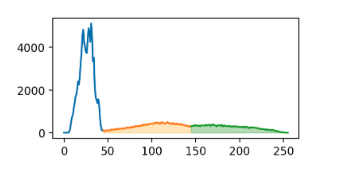

In [ ]:
from IPython.display import Image 
Image('./Images/creating_mask.png')

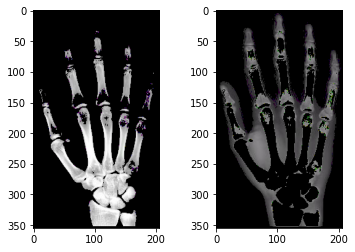

In [ ]:
import scipy.ndimage as ndi

# Create skin and bone masks

#mask_bone = im >= 145
im_bone = np.where(im >= 145, im, 0)
#mask_skin = (im>=45)&(im<145)
im_skin = np.where((im>=45)&(im<145), im, 0)

# Plot the skin (0) and bone (1) masks
fig, axes = plt.subplots(1,2)
axes[0].imshow(im_bone, cmap='gray')
axes[1].imshow(im_skin, cmap='gray')
#format_and_render_plot()

# for this particular dcm file, representation in images below is wrong, due to the differenet nature of image
#exercise in datacamp.com was made for another image

### Applying masks
Masks can be used to screen images, allowing the original values through except where the mask evaluates to False. NumPy's where() function is useful for this purpose. where() applies a condition on each pixel, and instead of returning a Boolean, it returns x when True and y when False. Each of the arguments can be either arrays or single values, allowing for great flexibility. To see this in action, first import NumPy. Let's try to filter out pixels that are not part of the bone. We'll call "where im is greater than 64, return im, otherwise return 0”. Plotting the masked image shows that only the high-intensity values remain, and these are mostly bone.

#### Exercise: Apply a mask

Although masks are binary, they can be applied to images to filter out pixels where the mask is False.

NumPy's where() function is a flexible way of applying masks. It takes three arguments:

`np.where(condition, x, y)`
condition, x and y can be either arrays or single values. This allows you to pass through original image values while setting masked values to 0.

Let's practice applying masks by selecting the bone-like pixels from the hand x-ray (im).

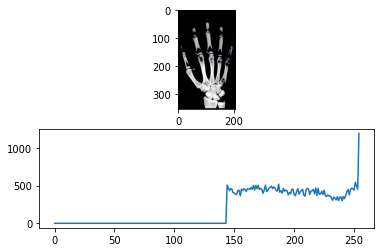

In [ ]:
# Apply a mask
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi

# Screen out non-bone pixels from "im"
#mask_bone = im >= 145
im_bone = np.where(im >= 145, im, 0)

# Get the histogram of bone intensities
hist = ndi.histogram(im_bone, 1, 255, 255)

# Plot masked image and histogram
fig, axes = plt.subplots(2,1)
axes[0].imshow(im_bone)
axes[1].plot(hist)
#format_and_render_plot()

### Tuning masks
Data is noisy, so your masks will rarely be perfect. Fortunately, there are simple ways to improve them. To increase the size of your mask, you can add pixels around the edges, a process known as dilation. This can help when the edges are fuzzy or to make sure you don't accidentally mask out pixels you actually care about. To do this, we call the binary_dilation() function, which converts all background pixels adjacent to the mask into mask pixels.

The opposite operation, "binary erosion" can be implemented in the same manner. Use it to cut the mask down to its more central pixels. You can perform these tuning operations many iterations to make your mask much larger or smaller. You can also combine the operations to open or close holes in your mask.

#### Exercise: Tune a mask
Imperfect masks can be tuned through the addition and subtraction of pixels. SciPy includes several useful methods for accomplishing these ends. These include:

*   `binary_dilation`: Add pixels along edges
*   `binary_erosion`: Remove pixels along edges
*   `binary_opening`: Erode then dilate, "opening" areas near edges
*   `binary_closing`: Dilate then erode, "filling in" holes

For this exercise, create a bone mask then tune it to include additional pixels.

For the remaining exercises, we have run the following import for you:

import scipy.ndimage as ndi

In [ ]:
'''# Tune a mask
# Create and tune bone mask
#mask_bone = im >= 145
mask_bone = np.where(mask_bone >= 145, im, 0)
mask_dilate = ndi.binary_dilation(mask_bone, iterations=5)
mask_closed = ndi.binary_closing(mask_bone, iterations=5)

# Plot masked images
fig, axes = plt.subplots(1,3)
axes[0].imshow(mask_bone)
axes[1].imshow(mask_dilate)
axes[2].imshow(mask_closed)
#format_and_render_plot()
'''

'# Tune a mask\n# Create and tune bone mask\n#mask_bone = im >= 145\nmask_bone = np.where(mask_bone >= 145, im, 0)\nmask_dilate = ndi.binary_dilation(mask_bone, iterations=5)\nmask_closed = ndi.binary_closing(mask_bone, iterations=5)\n\n# Plot masked images\nfig, axes = plt.subplots(1,3)\naxes[0].imshow(mask_bone)\naxes[1].imshow(mask_dilate)\naxes[2].imshow(mask_closed)\n#format_and_render_plot()\n'

Sometimes simpler methods for applying a mask such as multiplication (e.g.,  **im * mask_bone**) will meet your needs, but np.where() is an excellent tool to have in your arsenal.

##FILTERS

So far, we have only considered the images as a whole. However, you can combine intensity and spatial information by employing convolutional filters.

Two common examples of filtering are smoothing and sharpening. Smoothing emphasizes large intensity patterns in an image by reducing variability between neighboring pixels. Essentially, it suppresses noise by blurring the image. Image sharpening is the opposite: sharp changes are enhanced, exaggerating the differences between pixels. Let's look more closely at how this is accomplished.

###Convolution with a sharpening filter
Here we have a five by five input array, where all the values are one except for the center value of 2. To get a sharpened value for the center pixel, we would first define a set of filter weights, also called a kernel. Then, we would select a window of input data of the same size as our kernel. In this case, the filter will highly weight the center pixel and down-weight the adjacent pixels.

To perform convolution, we multiply these two matrices element-wise, and then we sum them up. In the top-left corner, we have an input value of 1 times a weight of 0, an input value of 1 times a weight of negative 1, and so on. We then sum all these products to get a new, sharpened value for the center pixel of our input image. In this case, it's been increased from two to six.

Let's see how this works on a full-size image. On the left is a random 2D array; on the right, we have an empty output image that we will create. In between is the sharpening kernel.

Starting from the top-left corner of the input image, we select the values surrounding the origin pixel. We then multiply each element in this selection by the kernel weights and add them together to get the filtered value. We take one step over to the next element, multiply the input window by the kernel, and repeat the process for each pixel in the image. This results, in this case, in a sharpened image.



#### Exercise: Filter Convolutions
Filters are an essential tool in image processing. They allow you to transform images based on intensity values surrounding a pixel, rather than globally.

For this exercise, smooth the foot radiograph. First, specify the weights to be used. (These are called "footprints" and "kernels" as well.) Then, convolve the filter with im and plot the result.


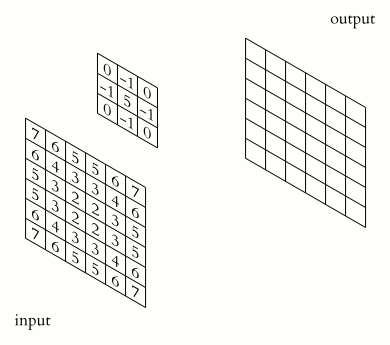

In [ ]:
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif('./Images/ConvolutionGif.gif')

Data type: uint8
Min. value: 0
Max value: 255


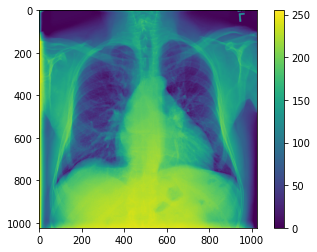

In [ ]:
# Load the radiograph
im = imageio.imread('./Data/dicom_00000001_000.dcm')
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()
#format_and_render_plot()

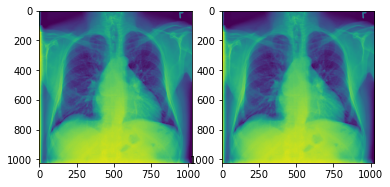

In [ ]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
           [0.11, 0.11, 0.11]]

# Convolve the image with the filter
im_filt = ndi.convolve(im, weights)

# Plot the images
fig, axes = plt.subplots(1,2)
axes[0].imshow(im)
axes[1].imshow(im_filt)
#format_and_render_plot()

###Image convolution###
We can apply custom filters using the convolve() function. First, we import packages and load the foot x-ray. Next, we create the kernel. In this case, let's average the center pixel with its neighbors to smooth out variability between pixels. After filtering, the major patterns will remain, but subtle variation between pixels will be dampened. Next, we call ndimage dot convolve() and pass in the image and weights. This produces a smoothed output image of the same size as our input.

###Filtering functions###
Filtering can also employ functions other than convolutional kernels, such as the mean, median, and maximum. SciPy has several of these functions built-in. Filter kernels do not have to be three by 3; they can be as large as you want. Here, we apply a ten by ten median filter to the foot image. You can see it does quite a nice job of smoothing out the variations in intensity.

####Exercise: Filter Functions

Convolutions rely on a set of weights, but filtering can also be done using functions such as the mean, median and maximum. Just like with convolutions, filter functions will update each pixel value based on its local neighborhood.

Consider the following lines of code:



In [ ]:
im1 = np.array([[93, 36,  87], 
               [18, 49,  51],
               [45, 32,  63]])

im_filt = ndi.median_filter(im1, size=3)
# Alternatives in the task:
# ndi.maximum_filter(im1, size=3)
# ndi.uniform_filter(im1, size=3)
# ndi.percentile_filter(im1, 60, size=3)

assert im_filt[1,1] == 49

###Gaussian filtering###
Finally, the Gaussian filter is useful for smoothing data across larger areas. It blurs activation based on a Gaussian, or normal, distribution around the filtered pixel. Basically, the filter weights dissipate in a circular pattern as you get further from the center. The width of the distribution is controlled by the sigma parameter. Applying a Gaussian filter can be a great way to reduce noise, but with very large sigma values, you'll lose a lot of detail in your image.

####Exercise: Smoothing with Gaussian Filter
Smoothing can improve the **signal-to-noise** ratio of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.

The width of the distribution is controlled by the sigma argument, with higher values leading to larger smoothing effects.

For this exercise, test the effects of applying Gaussian filters to the foot x-ray before creating a bone mask.£

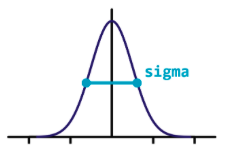

In [ ]:
Image('./Images/smoothing.png')

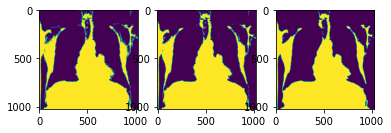

In [ ]:
# Smooth "im" with Gaussian filters
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, axes = plt.subplots(1,3)
axes[0].imshow(im >= 145)
axes[1].imshow(im_s1 >= 145)
axes[2].imshow(im_s3 >= 145)
#format_and_render_plot()

##FEATURE DETECTION
Filters aren't just useful for blurring and smoothing. They can also be used as detectors for features of interest, such as edges.

###Edges: sharp changes in intensity
If we want to construct a filter kernel that will emphasize edges, what should it look like? Recall that when we perform convolution, it creates a new image that reflects what the filter looks like: a smoothing filter itself has a smooth gradient, whereas a sharpening filter has a sudden change in intensity. An edge is a change in intensity along an axis. Sharp edges, for example, between the skull and background in this MRI image, have very high contrast. The filter should reflect this.

###Edge detection
Let's see if we can make this work. We start by loading the foot x-ray. Next, we construct our kernel: to look for areas that have a change in intensity from top to bottom. We can weight the top row to positive 1 and the bottom row to negative 1. Essentially, this filter calculates the difference between the top and bottom rows, returning values far from 0 when there is a sudden change in intensity. Then, we convolve the image with the filter using SciPy. Plotting the image, it's clear that our detector has done a fine job of highlighting some edges. But note two things: First, this is a horizontal edge detector because it is looking for differences between the top and bottom values at each point. If you look at the vertical edges in the filtered image, you'll see that they have relatively low values compared to the top and bottom of the foot. Second, there are both positive and negative values. This happens because some edges have high-intensity values on top and low values on bottom, whereas others have the opposite. The direction of this difference determines whether the convolution yields a positive or negative value.

####Exercise: Filter to Detect Edges

Filters can also be used as "detectors." If a part of the image fits the weighting pattern, the returned value will be very high (or very low).

In the case of edge detection, that pattern is a change in intensity along a plane. A filter detecting horizontal edges might look like this:



```
weights = [[+1, +1, +1],
           [ 0,  0,  0],
           [-1, -1, -1]]
```



For this exercise, create a vertical edge detector and see how well it performs on the hand x-ray (im).

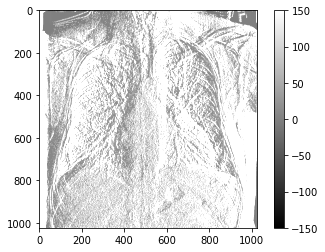

In [ ]:
# Part1: Filter to Detect Edges
# Set weights to detect vertical edges
weights = [[+1, 0, -1], [+1, 0, -1], [+1, 0, -1]]


# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.imshow(edges, cmap='gray', vmin=-150, vmax=150)
plt.colorbar()
#format_and_render_plot()

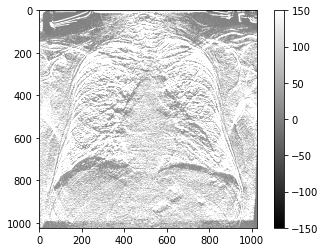

In [ ]:
# Part2: Filter to Detect Edges
# Set weights to detect horizontal edges
weights = [[+1, +1, +1], [0, 0, 0], [-1, -1, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.imshow(edges, cmap='gray', vmin=-150, vmax=150)
plt.colorbar()
#format_and_render_plot()

### Sobel filters
There are many possible configurations for edge detectors. A very common one is the Sobel operator, which provides an extra weight to the center pixels of the kernel. The filter can be rotated to make it sensitive to either horizontal or vertical edges.

Implementing the Sobel filter is just like implementing other filters: call ndimage dot sobel(), then pass in the image and the orientation of the filter.


### Sobel filter magnitude
To remedy the fact that we have multiple edge maps with positive and negative values, we can create a composite edge map. Recall the Pythagorean Theorem - when you have two perpendicular vectors, you can calculate their distance by taking the root of their squares. This is useful in our situation: if we apply the Sobel filter along the first and second axes, we can then use these as input to the Pythagorean Theorem to get a composite, positively weighted edge image. This nicely highlights intensity changes in our image, and we can use these features for masking or object detection in later analysis steps.

####Exercise: Sobel Filter To Detect Edges

Edge detection can be performed along multiple axes, then combined into a single edge value. For 2D images, the horizontal and vertical "edge maps" can be combined using the Pythagorean theorem: 


```
z = sqrt(x**2 + y**2)
```

One popular edge detector is the Sobel filter. The Sobel filter provides extra weight to the center pixels of the detector:


```
weights = [[ 1,  2,  1], 
           [ 0,  0,  0],
           [-1, -2, -1]]
```

For this exercise, improve upon your previous detection effort by merging the results of two Sobel-filtered images into a composite edge map.

In [ ]:
# Apply Sobel filter along both axes:
sobel_ax0 = ndi.sobel(im, axis=0)
sobel_ax1 = ndi.sobel(im, axis=1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0) +
                np.square(sobel_ax1))

# Plot edge magnitude
plt.imshow(edges,cmap='gray', vmax=75)

#format_and_render_plot()


## REFERENCES:


*   [Datacamp course "BIOMEDICAL IMAGE ANALYSIS":](https://campus.datacamp.com/courses/biomedical-image-analysis-in-python/exploration?ex=3)
*   ["Decode DICOM files for medical imaging" Colab Notebook](https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/dicom.ipynb#scrollTo=qFdPvlXBOdUN)  
*   [Imageio documentation](https://imageio.readthedocs.io/en/stable/examples.html)